# Testing task with meat classification

## Dependencies

In [ ]:
!pip install sacremoses

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 43.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895241 sha256=7dac68de8431ab384d7e665f71c8f989ffbae66e654b0936311058650bd422f7
  Stored in directory: /root/.cache/pip/wheels/00/24/97/a2ea5324f36bc626e1ea0267f33db6aa80d157ee977e9e42fb
Successfully built sacremoses


In [ ]:
import time
import pandas as pd
import torch
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split

from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchtext.data.utils import get_tokenizer
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
from torchtext.vocab import build_vocab_from_iterator

import matplotlib.pyplot as plt
import seaborn as sns

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
MIN_LABELS = 500 # Min number of labels to form a class
EM_SIZE = 64 # Embedding size for text tokenization
TEST_SIZE = 0.2 # Train/test split
SEED = 42

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Custom dataset to load data into



In [ ]:
class CustomTextDataset(Dataset):
    def __init__(self, csv_file):
        df = pd.read_csv(csv_file,sep=';')
        df.dropna(inplace = True)
        df = df[df.groupby('mtype')['mtype'].transform('count').ge(MIN_LABELS)]
        df.reset_index(inplace=True)
        print(df.mtype.value_counts(sort=True))

        labels = df.mtype.unique()
        self.labels_dict = {word:num for num, word in enumerate(labels)}
        self.targets = [self.labels_dict[label] for label in df.mtype]
        self.text = df.text        
    def __len__(self):
        return self.df.shape[0]
    def __getitem__(self, idx):
        label = self.targets[idx]
        text = self.text[idx]
        sample = (label, text)
        return sample

In [ ]:
our_dataset = CustomTextDataset('https://axe.inline-ltd.ru/data/meatinfo.csv')

Говядина    8422
Свинина     3050
Кура        1571
Индейка     1337
Баранина    1116
Цыпленок     942
Name: mtype, dtype: int64


## Data processing pipeline

In [ ]:
#Train/test split with equal proportions of classes
train_indices, test_indices, _, _ = train_test_split(
    range(len(our_dataset.targets)),
    our_dataset.targets,
    stratify=our_dataset.targets,
    test_size=TEST_SIZE,
    random_state=SEED
)

# generate subsets based on indices
train_split = Subset(our_dataset, train_indices)
test_split = Subset(our_dataset, test_indices)

In [ ]:
tokenizer = get_tokenizer("moses",language='russian')

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_split), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [ ]:
text_pipeline = lambda x: vocab(tokenizer(x))

In [ ]:
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
         label_list.append(_label)
         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

### Check test distribution

In [ ]:
meat_label = {y: x for x, y in our_dataset.labels_dict.items()}
items = []
for el in test_split:
    items.append(el[0])
test_dist = dict(zip(items,[items.count(i) for i in items]))
test_distribution = {meat_label[key]:test_dist[key] for key in test_dist.keys()}
dict(sorted(test_distribution.items(), key=lambda item: item[1],reverse=True))

{'Говядина': 1685,
 'Свинина': 610,
 'Кура': 314,
 'Индейка': 268,
 'Баранина': 223,
 'Цыпленок': 188}

## Classification model

In [ ]:
class MeatClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(MeatClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [ ]:
num_class = len(set([label for (label, text) in train_split]))
vocab_size = len(vocab)

In [ ]:
model = MeatClassificationModel(vocab_size, EM_SIZE, num_class).to(device)

## Training

In [ ]:
def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 200
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()
    return total_acc/total_count

def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

In [ ]:
# Hyperparameters
EPOCHS = 7 # epoch
LR = 0.1  # learning rate
BATCH_SIZE = 16 # batch size for training

criterion = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=LR)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None

train_dataset = to_map_style_dataset(train_split)
test_dataset = to_map_style_dataset(test_split)
num_train = int(len(train_dataset))

num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = \
    random_split(train_dataset, [num_train, len(train_dataset) - num_train])

train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=collate_batch)

val_acc_history = []
acc_history = []

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_acc = train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    val_acc_history.append(accu_val)
    acc_history.append(train_acc)
    if total_accu is not None and total_accu > accu_val:

      scheduler.step()
    else:
       total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)

| epoch   1 |   200/  781 batches | accuracy    0.854
| epoch   1 |   400/  781 batches | accuracy    0.904
| epoch   1 |   600/  781 batches | accuracy    0.916
-----------------------------------------------------------
| end of epoch   1 | time:  8.23s | valid accuracy    0.907 
-----------------------------------------------------------
| epoch   2 |   200/  781 batches | accuracy    0.961
| epoch   2 |   400/  781 batches | accuracy    0.960
| epoch   2 |   600/  781 batches | accuracy    0.960
-----------------------------------------------------------
| end of epoch   2 | time:  8.36s | valid accuracy    0.916 
-----------------------------------------------------------
| epoch   3 |   200/  781 batches | accuracy    0.976
| epoch   3 |   400/  781 batches | accuracy    0.975
| epoch   3 |   600/  781 batches | accuracy    0.972
-----------------------------------------------------------
| end of epoch   3 | time:  8.58s | valid accuracy    0.932 
-------------------------------

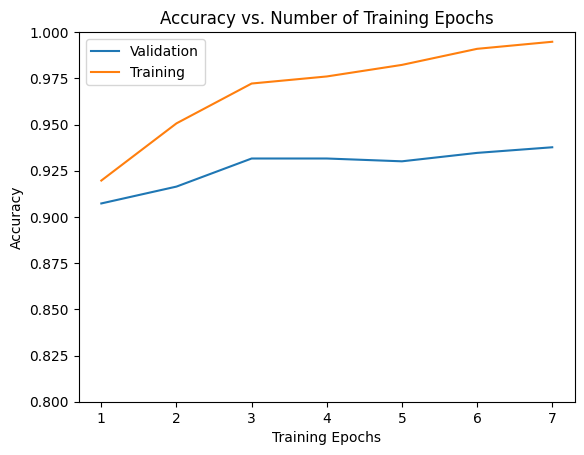

In [ ]:
plt.title("Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1,EPOCHS+1),val_acc_history,label="Validation")
plt.plot(range(1,EPOCHS+1),acc_history,label="Training")
plt.ylim((0.8,1.))
plt.xticks(np.arange(1, EPOCHS+1, 1.0))
plt.legend()
plt.show()

## Evaluation

In [ ]:
def evaluate_classes(dataloader):
    confusion_matrix = torch.zeros(num_class, num_class)
    with torch.no_grad():
        for i, (classes, inputs, offsets) in enumerate(dataloader):
            outputs = model(inputs,offsets)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
    # print(confusion_matrix)
    # print(confusion_matrix.diag()/confusion_matrix.sum(1))
    return confusion_matrix

In [ ]:
print('Checking the results of test dataset.')
accu_test = evaluate(test_dataloader)
print('test accuracy {:8.3f}'.format(accu_test))

Checking the results of test dataset.
test accuracy    0.939


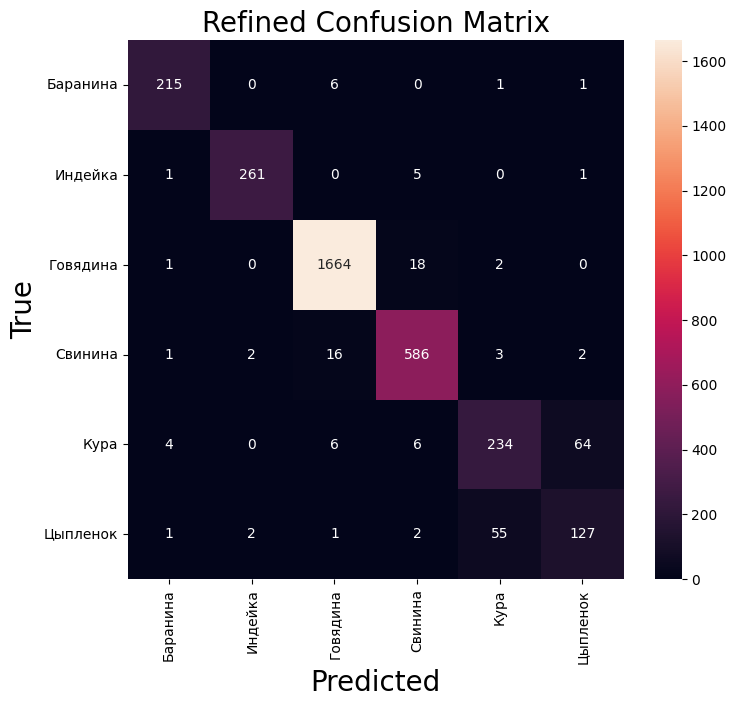

In [ ]:
cm = evaluate_classes(test_dataloader)

## Get Class Labels
class_names = our_dataset.labels_dict.keys()

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(8, 7))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Refined Confusion Matrix', fontsize=20)
plt.show()

In [ ]:
meat_label = {y: x for x, y in our_dataset.labels_dict.items()}

In [ ]:
def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item()

In [ ]:
model.to("cpu")

MeatClassificationModel(
  (embedding): EmbeddingBag(20623, 64, mode='mean')
  (fc): Linear(in_features=64, out_features=6, bias=True)
)

In [ ]:
input_text = 'Говядина блочная 2 сорт в наличии ООО "АгроСоюз" реализует блочную говядину 2 сорт (80/20) Свободный объем 8 тонн Самовывоз или доставка. Все подробности по телефону.'
print("Это %s" %meat_label[predict(input_text, text_pipeline)])

Это Говядина


In [ ]:
input_text = 'Куриная разделка Продам кур и куриную разделку гост и халяль по хорошей цене .Тел:'
print("Это %s" %meat_label[predict(input_text, text_pipeline)])

Это Кура


In [ ]:
input_text = 'Говяжью мукозу Продам говяжью мукозу в охл и замороженном виде. Есть объем.'
print("Это %s" %meat_label[predict(input_text, text_pipeline)])

Это Говядина
